# Simple PPO

We will implement a very simple single-threaded version of PPO using only one actor and then attempt to solve the CartPole-v1 task.

## Critic
The critic will approximate the value function by training a neural net using the TD(λ) algorithm.

In [770]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class CriticNet(nn.Module):
    def __init__(self):
        super().__init__()
        # CartPole-v1 observation is a 4-dimensional vector of floats
        # self.fc1 = nn.Linear(4, 10)
        # We want to output a scalar state value
        # self.fc2 = nn.Linear(10, 1)
        self.fc1 = nn.Linear(4, 1)
        init.zeros_(self.fc1.weight)
        init.zeros_(self.fc1.bias)
        
        # initialize weights
        #for layer in [self.fc1, self.fc2]:
        #    init.xavier_uniform_(layer.weight)
        #    init.zeros_(layer.bias)
    
    def forward(self, x):
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc1(x)
        return x

class Critic:
    """Approximate value function with TD(λ).
    
    Arguments:
    learning_rate — corresponds to α in Sutton
    trace_decay_rate — corresponds to λ in Sutton
    """
    def __init__(self, learning_rate, trace_decay_rate):
        self.learning_rate = learning_rate
        self.trace_decay_rate = trace_decay_rate
        self.critic_net = CriticNet()
        self.eligibility_trace = [
            torch.zeros_like(parameter.data)
            for parameter in self.critic_net.parameters()
        ]
    
    def step(self, previous_state, state, reward):
        """Compute TD error and perform one step of optimization of critic_net.
        
        Arguments:
        previous_state — corresponds to S_t in Sutton.
        state — corresponds to S_{t+1} in Sutton.
        reward — corresponds to R_{t+1} in Sutton.
        
        Return approximate value of previous_state, approximate value of state.
        """
        self.critic_net.zero_grad()
        previous_state_value = self.critic_net(previous_state)
        previous_state_value.backward()
        state_value = self.critic_net(state)
        
        #for i, parameter in enumerate(self.critic_net.parameters()):
        #    self.eligibility_trace[i] *= self.trace_decay_rate
        #    self.eligibility_trace[i] += parameter.grad.data
        
        td_error = reward + state_value.item() - previous_state_value.item()
        tde.append(td_error)
        for i, parameter in enumerate(self.critic_net.parameters()):
            #parameter.data += self.learning_rate * td_error * self.eligibility_trace[i]
            parameter.data += self.learning_rate * td_error * parameter.grad.data
        
        return previous_state_value.item(), state_value.item()

# Actor
The actor will record a trajectory of a fixed size and estimate advantages via GAE.

In [616]:
class Actor:
    def __init__(self, env, critic, trajectory_length, gae_gamma, gae_lambda):
        """Record trajectory of fixed length and estimate advantages via (truncated) GAE.
        
        Arguments:
        env — environment implementing OpenAI gym interface.
        critic — reference to critic, as defined above
        trajectory_length — length of trajectory to record from env at each step.
        gae_gamma — γ parameter from GAE paper.
        gae_lambda — λ parameter from GAE paper.
        """
        self.env = env
        self.critic = critic
        self.trajectory_length = trajectory_length
        self.gae_gamma = gae_gamma
        self.gae_lambda = gae_lambda
        self.state = None
        self.done = True
    
    def step(self, policy):
        """Perform single step, recording trajectory of fixed length and estimating advantages.
        
        Arguments:
        policy — current policy, implementing sample_action(state) that chooses
        the next action when in a given state according to the policy.
        
        Return the states encountered, the actions encountered, and the computed advantages.
        """
        trajectory_states = torch.zeros(self.trajectory_length, 4)
        trajectory_actions = torch.zeros(self.trajectory_length)
        td_errors = torch.zeros(self.trajectory_length)
        
        for t in range(self.trajectory_length):
            if self.done:
                self.state = torch.tensor(self.env.reset(), dtype=torch.float32)
                
            trajectory_states[t] = self.state
            action = policy.sample_action(self.state)
            assert action in [0, 1]
            trajectory_actions[t] = action
            previous_state = self.state
            self.state, reward, done, _ = env.step(action)
            self.state = torch.tensor(self.state, dtype=torch.float32)
            previous_state_value, state_value = self.critic.step(previous_state, self.state, reward)
            td_errors[t] = reward + self.gae_gamma * state_value - previous_state_value
        
        #advantages = torch.zeros(self.trajectory_length)
        #previous_advantage = 0
        #
        #for t in range(self.trajectory_length - 1, -1, -1):
        #    advantage = self.gae_gamma * self.gae_lambda * previous_advantage + td_errors[t]
        #    advantages[t] = advantage
        #    previous_advantage = advantage
        advantages = td_errors
        
        return trajectory_states, trajectory_actions, advantages

 ## Policy
 We will use a parametric policy that computes preference scores via a neural network and computes probabilities as the softmax of the preference scores.

In [617]:
import random

class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__() 
        # CartPole-v1 observation is a 4-dimensional vector of floats
        self.fc1 = nn.Linear(4, 1000)
        # We want to output a preferences score for each of the two actions.
        self.fc2 = nn.Linear(1000, 2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

def softmax(x):
    """Compute softmax vector of the vector x.
    
    This function supports vectorization. That is,
    softmax(torch.stack([t1, t2, ...])) is equal to
    torch.tensor([softmax(t1), softmax(t2), ...])
    """
    exps = torch.exp(x)
    if x.dim() == 1:
        return exps / torch.sum(exps)
    elif x.dim() == 2:
        return torch.true_divide(exps, torch.sum(exps, dim=1).reshape(-1, 1))

class Policy:
    def __init__(self):
        self.policy_net = PolicyNet()
    
    def sample_action(self, state):
        preference_scores = self.policy_net(state)
        probabilities = softmax(preference_scores)
        # action for CartPole-v1 is either 0 or 1
        action = random.choices(
            [0, 1],
            weights=probabilities
        )[0]
        return action
    
    def probability(self, state, action):
        preference_scores = self.policy_net(state)
        probabilities = softmax(preference_scores)
        
        if state.dim() == 1:
            return probabilities[action]
        elif state.dim() == 2:
            return torch.gather(probabilities, 1, action.reshape(-1, 1).long()).flatten()

## PPO
Finally, we actually implement the PPO algorithm. We follow the "actor-critic style" pseudocode given in the PPO paper, using only a single thread and setting $N=1$ (using only one actor).

In [618]:
class PPO:
    def __init__(self, actor, policy, learning_rate, epsilon, K):
        self.actor = actor
        self.policy = policy
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.K = K
    
    def step(self):
        trajectory_states, trajectory_actions, advantages = self.actor.step(self.policy)
        advantages = advantages.detach()
        old_probability = policy.probability(trajectory_states, trajectory_actions).detach()
        print(f'adv = {advantages}')
        
        first_objective = None
        last_objective = None
        
        for epoch in range(self.K):
            probability = policy.probability(trajectory_states, trajectory_actions)
            ratio = probability / old_probability
            objective = torch.mean(
                torch.min(torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon) * advantages, ratio * advantages)
            )
            
            if epoch == 0:
                first_objective = objective.item()
            elif epoch == self.K - 1:
                last_objective = objective.item()
            
            policy.policy_net.zero_grad()
            objective.backward()
        
            for parameter in policy.policy_net.parameters():
                parameter.data += self.learning_rate * parameter.grad.data
        
        return first_objective, last_objective

# Evaluation

In [619]:
def evaluate_policy_episode(env, policy):
    state = env.reset()
    score = 0
    
    while True:
        action = policy.sample_action(torch.tensor(state, dtype=torch.float32))
        state, reward, done, _ = env.step(action)
        score += reward
        
        if done:
            break
            
    return score

def evaluate_policy(env, policy, num_episodes=10):
    total_score = 0
    
    for _ in range(num_episodes):
        total_score += evaluate_policy_episode(env, policy)
    
    return total_score / num_episodes

In [620]:
import gym

env = gym.make('CartPole-v1')
policy = Policy()
critic = Critic(0.01, 0.8)
actor = Actor(env, critic, 100, 0.96, 0.98)
ppo = PPO(actor, policy, 0.01, 0.2, 10)
perf = []
first = []
last = []
tde = []

In [652]:
ppo.step()

adv = tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


(1.0, 1.0)

In [653]:
tde

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [665]:
critic.critic_net(torch.randn(100, 4, dtype=torch.float))

tensor([[0.0000],
        [0.0000],
        [0.0681],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0904],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0919],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.1199],
        [0.0000],
        [0.0000],
        [0.0821],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.1590],
        [0.0000],
        [0.0000],
        [0.3560],
        [0.0000],
        [0.0584],
        [0.0000],
        [0.0000],
        [0.3035],
        [0.0000],
        [0.0233],
        [0.0000],
        [0.0647],
        [0.0000],
        [0.1458],
        [0.0000],
        [0

In [668]:
[p.grad for p in list(critic.critic_net.parameters())]

[tensor([[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [179]:
for i in range(5):
    for j in range(100):
        f, l = ppo.step()
        first.append(f)
        last.append(l)
    perf.append(evaluate_policy(env, policy))

KeyboardInterrupt: 

In [782]:
env = gym.make('CartPole-v1')
critic_net = CriticNet()
tde = []

In [789]:
def step():
    states = [env.reset()]
    rewards = []
    state_values = [critic_net(torch.tensor(states[0], dtype=torch.float))]
    
    while True:
        state, reward, done, _ = env.step(env.action_space.sample())
        states.append(state)
        rewards.append(reward)
        state_values.append(critic_net(torch.tensor(state, dtype=torch.float)))
        
        if done:
            break
    
    for j in range(len(states) - 1):
        reward = rewards[j]
        previous_state_value = state_values[j]
        state_value = state_values[j + 1]
            
        critic_net.zero_grad()
        previous_state_value.backward()
        td_error = reward + state_value - previous_state_value
            
        for p in critic_net.parameters():
            p.data += 0.03 * td_error * p.grad.data

In [790]:
for _ in range(1000):
    step()

RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling backward the first time.

In [780]:
import numpy as np

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

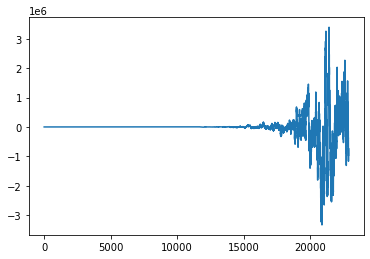

In [781]:
plt.plot(running_mean(tde, 100))